In [1]:
import caffe
import lmdb
import glob
import skimage
from skimage import io
import numpy
from skimage.transform import resize
import numpy as np
from caffe import layers as L
from caffe import params as P
from pylab import *
import pandas as pd
%matplotlib inline

In [26]:
# get the filenames of train image
df_trainall = pd.read_csv('/home/ubuntu/caffe/yelp/pic_label_trainall.csv')
print len(df_trainall)
print df_trainall.ix[:2,]
print df_trainall.ix[0,0]
filename = '/home/ubuntu/caffe/yelp/train_photos/train_photos/' + str(df.ix[0,0]) + '.jpg'
print filename
img = io.imread(filename)
print img.shape
img = resize(img, (80, 80, 3))
map_size = img.nbytes*1000000000

234842
   photo_id  business_id  label_0  label_1  label_2  label_3  label_4  \
0    204149         3034        0        0        0        1        0   
1     52779         2805        0        1        1        1        0   
2    278973          485        0        1        1        1        1   

   label_5  label_6  label_7  label_8  label_9  
0        0        0        0        1        0  
1        1        1        1        0        0  
2        1        1        1        0        0  
204149
/home/ubuntu/caffe/yelp/train_photos/train_photos/204149.jpg
(500, 373, 3)


In [20]:
# get the labels of train image
label_train_df = pd.read_csv('/home/ubuntu/caffe/yelp/pic_label_trainall.csv', sep = ',' )
labels = np.array(label_train_df.ix[:,2])
print len(labels)

234842


In [27]:
# read train image and labels into lmdb
env = lmdb.open('/home/ubuntu/caffe/yelp/trainall_0_lmdb', map_size = map_size)
with env.begin(write=True) as txn:
    # txn is a Transaction object
    for i in range(len(df_trainall)):
        filename = '/home/ubuntu/caffe/yelp/train_photos/train_photos/' + str(df_trainall.ix[i,0]) + '.jpg'
        img = io.imread(filename)
        img = resize(img, (80, 80, 3))
        x, y, z = img.shape
        all_elements = x*y*z
        img_re = img.reshape(all_elements)
        img_r = img_re[0:all_elements:3]
        img_g = img_re[1:all_elements:3]
        img_b = img_re[2:all_elements:3]
        img_re = numpy.array([img_r, img_g, img_b])
        datum = caffe.proto.caffe_pb2.Datum()
        datum.channels = img.shape[2]
        datum.height = img.shape[0]
        datum.width = img.shape[1]
        datum.data = img_re.tobytes()
        datum.label = int(labels[i])
        str_id = '{:08}'.format(i)
        txn.put(str_id, datum.SerializeToString())

In [4]:
# # get the filenames of test image
# image_filenames_test = glob.glob('/home/ubuntu/caffe/yelp/testnew/testnew/*')
# filename = image_filenames_test[0]
# img = io.imread(filename)
# img = resize(img, (80, 80, 3))
# map_size = img.nbytes*100000
# print map_size
# print len(image_filenames_test)

1920000000
15167


In [4]:
df_testsample = pd.read_csv('/home/ubuntu/caffe/yelp/pic/pic_label_subbybus_test.csv')
# print len(df_testsample)
# print df_testsample.ix[:2,]
# print df_testsample.ix[0,0]
filename = '/home/ubuntu/caffe/yelp/test_sample/test_sample/' + str(df_testsample.ix[0,0]) + '.jpg'
# print filename
img = io.imread(filename)
print img.shape
img = resize(img, (250, 250, 3))
map_size = img.nbytes*100000

(250, 250, 3)


In [5]:
# get the labels of test image
label_test_df = pd.read_csv('/home/ubuntu/caffe/yelp/pic/pic_label_subbybus_test.csv', sep = ',')
labels_test = np.array(label_test_df.ix[:,'label_0'])
photos_test = np.array(label_test_df.ix[:,'photo_id'])
print len(photos_test)

15167


In [6]:
# read test image and labels into lmdb
env = lmdb.open('/home/ubuntu/caffe/yelp/test_0_lmdb_250size', map_size = map_size)
with env.begin(write=True) as txn:
    # txn is a Transaction object
    for i in range(len(df_testsample)):
        filename = '/home/ubuntu/caffe/yelp/test_sample/test_sample/' + str(photos_test[i]) + '.jpg'
        img = io.imread(filename)
        
        img = resize(img, (250, 250, 3))
        
        x, y, z = img.shape
        all_elements = x*y*z
        img_re = img.reshape(all_elements)
        img_r = img_re[0:all_elements:3]
        img_g = img_re[1:all_elements:3]
        img_b = img_re[2:all_elements:3]
        img_re = numpy.array([img_r, img_g, img_b])
        datum = caffe.proto.caffe_pb2.Datum()
        datum.channels = img.shape[2]
        datum.height = img.shape[0]
        datum.width = img.shape[1]
        datum.data = img_re.tobytes()
        datum.label = int(labels_test[i])
        str_id = '{:08}'.format(i)
        txn.put(str_id, datum.SerializeToString())

In [2]:
# from caffe import layers as L
# from caffe import params as P

def lenet(lmdb, batch_size):
    # our version of LeNet: a series of linear and simple nonlinear transformations
    n = caffe.NetSpec()
    n.data, n.label = L.Data(batch_size=batch_size, backend=P.Data.LMDB, source=lmdb,
                             transform_param=dict(scale=1./255), ntop=2)
    n.conv1 = L.Convolution(n.data, kernel_size=5, num_output=20, weight_filler=dict(type='xavier'))
    n.pool1 = L.Pooling(n.conv1, kernel_size=2, stride=2, pool=P.Pooling.MAX)
    n.conv2 = L.Convolution(n.pool1, kernel_size=5, num_output=50, weight_filler=dict(type='xavier'))
    n.pool2 = L.Pooling(n.conv2, kernel_size=2, stride=2, pool=P.Pooling.MAX)
#     n.ip1 = L.InnerProduct(n.pool2, num_output=500, weight_filler=dict(type='uniform'))
    n.ip1 = L.InnerProduct(n.pool2, num_output=500, weight_filler=dict(type='xavier'))
    n.relu1 = L.ReLU(n.ip1, in_place=True)
    n.ip2 = L.InnerProduct(n.relu1, num_output=2, weight_filler=dict(type='xavier'))
    n.loss =  L.SoftmaxWithLoss(n.ip2, n.label)
    n.prob = L.Softmax(n.ip2)
    return n.to_proto()
    
with open('/home/ubuntu/caffe/yelp/yelp_train.prototxt', 'w') as f:
    f.write(str(lenet('/home/ubuntu/caffe/yelp/train7_lmdb', 64)))
    
with open('/home/ubuntu/caffe/yelp/yelp_test.prototxt', 'w') as f:
    f.write(str(lenet('/home/ubuntu/caffe/yelp/test7_lmdb', 100)))
    
# run till here

In [19]:
print solver.test_nets[0].blobs['ip1'].data

[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]


In [24]:
!cat /home/ubuntu/caffe/yelp/yelp_train.prototxt

layer {
  name: "data"
  type: "Data"
  top: "data"
  top: "label"
  transform_param {
    scale: 0.00392156862745
  }
  data_param {
    source: "/home/ubuntu/caffe/yelp/train6_lmdb"
    batch_size: 64
    backend: LMDB
  }
}
layer {
  name: "conv1"
  type: "Convolution"
  bottom: "data"
  top: "conv1"
  convolution_param {
    num_output: 20
    kernel_size: 5
    weight_filler {
      type: "xavier"
    }
  }
}
layer {
  name: "pool1"
  type: "Pooling"
  bottom: "conv1"
  top: "pool1"
  pooling_param {
    pool: MAX
    kernel_size: 2
    stride: 2
  }
}
layer {
  name: "conv2"
  type: "Convolution"
  bottom: "pool1"
  top: "conv2"
  convolution_param {
    num_output: 50
    kernel_size: 5
    weight_filler {
      type: "xavier"
    }
  }
}
layer {
  name: "pool2"
  type: "Pooling"
  bottom: "conv2"
  top: "pool2"
  pooling_param {
    pool: MAX
    kernel_size: 2
    stride: 2
  }
}
layer {
  name: "ip1"
  type: "InnerProduct"
  bottom: "pool2"
  top: "ip1"
  inner_product_param 

In [3]:
# run
caffe.set_device(0)
caffe.set_mode_gpu()

In [4]:
# run
solver = caffe.SGDSolver('/home/ubuntu/caffe/yelp/yelp_solver.prototxt')

In [9]:
!cat '/home/ubuntu/caffe/yelp/yelp_solver.prototxt'

# The train/test net protocol buffer definition
train_net: "/home/ubuntu/caffe/yelp/yelp_train.prototxt"
test_net: "/home/ubuntu/caffe/yelp/yelp_test.prototxt"
# test_iter specifies how many forward passes the test should carry out.
# In the case of MNIST, we have test batch size 100 and 100 test iterations,
# covering the full 10,000 testing images.
test_iter: 100
# Carry out testing every 500 training iterations.
test_interval: 500
# The base learning rate, momentum and the weight decay of the network.
base_lr: 0.008
momentum: 0.9
weight_decay: 0.0009
# The learning rate policy
lr_policy: "inv"
gamma: 0.0001
power: 0.75
# Display every 100 iterations
display: 100
# The maximum number of iterations
max_iter: 10000
# snapshot intermediate results
snapshot: 5000
snapshot_prefix: "/home/ubuntu/caffe/yelp/yelp_snapshot"


In [10]:
# each output is (batch size, feature dim, spatial dim)
[(k, v.data.shape) for k, v in solver.net.blobs.items()]

[('data', (64, 3, 100, 100)),
 ('label', (64,)),
 ('conv1', (64, 30, 90, 90)),
 ('pool1', (64, 30, 21, 21)),
 ('conv2', (64, 50, 17, 17)),
 ('pool2', (64, 50, 9, 9)),
 ('ip1', (64, 500)),
 ('ip2', (64, 2)),
 ('ip2_ip2_0_split_0', (64, 2)),
 ('ip2_ip2_0_split_1', (64, 2)),
 ('loss', ()),
 ('prob', (64, 2))]

In [11]:
# just print the weight sizes (we'll omit the biases)
[(k, v[0].data.shape) for k, v in solver.net.params.items()]

[('conv1', (30, 3, 11, 11)),
 ('conv2', (50, 30, 5, 5)),
 ('ip1', (500, 4050)),
 ('ip2', (2, 500))]

In [14]:
solver.test_nets[0].blobs['prob'].data  # train net

array([[ 0.4277502 ,  0.57224983],
       [ 0.40920666,  0.59079337],
       [ 0.43928394,  0.56071603],
       [ 0.39375174,  0.60624826],
       [ 0.44659075,  0.55340922],
       [ 0.43860513,  0.56139487],
       [ 0.45532647,  0.54467356],
       [ 0.43882728,  0.56117278],
       [ 0.38965118,  0.61034882],
       [ 0.38209584,  0.61790413],
       [ 0.44994029,  0.55005968],
       [ 0.37647864,  0.62352133],
       [ 0.34437922,  0.65562081],
       [ 0.37829843,  0.62170154],
       [ 0.4234578 ,  0.5765422 ],
       [ 0.41374186,  0.58625817],
       [ 0.48331529,  0.51668471],
       [ 0.37044638,  0.62955362],
       [ 0.41037917,  0.58962089],
       [ 0.45443413,  0.5455659 ],
       [ 0.39954895,  0.60045105],
       [ 0.46498102,  0.53501892],
       [ 0.41649842,  0.58350158],
       [ 0.3660104 ,  0.63398957],
       [ 0.4287264 ,  0.57127351],
       [ 0.40385097,  0.59614903],
       [ 0.43424296,  0.56575698],
       [ 0.33871108,  0.66128892],
       [ 0.40509588,

In [56]:
solver.step(1)

In [57]:
solver.net.blobs['loss']

array(0.6633914709091187, dtype=float32)

In [ ]:
solver.net.blobs['prob']

In [13]:
print solver.test_nets[0].blobs['label'].data

[ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.
  1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  1.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.
  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  1.  0.  0.  0.
  1.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


In [39]:
solver.step(1)

In [16]:
test_out = solver.test_nets[0].forward()

In [15]:
len(solver.test_nets[0].blobs['label'].data)

100

In [22]:
test_out['prob']

array([ 0.43521285,  0.56478721], dtype=float32)

In [17]:
solver.test_nets[0].blobs['label'].data

array([ 1.,  1.,  1.,  0.,  1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.,  1.,
        0.,  1.,  1.,  1.,  1.,  1.,  1.], dtype=float32)

In [13]:
solver.net.blobs['label'].data

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.], dtype=float32)

In [23]:
np.concatenate(solver.test_nets[0].blobs['label'].data

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        0.,  1.,  1.,  0.,  0.,  1.,  1.,  1.,  1.,  1.,  0.,  0.,  1.,
        0.,  1.,  0.,  1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  0.,  1.,  0.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  0.,  1.,  1.,  0.,  1.,  1.,  1.,  0.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  0.,  1.,  1.,  0.,  1.,  0.,  1.,
        1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.,  1.,  0.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  0.,  0.,  1.,  1.,  1.], dtype=float32)

In [16]:
# solver.net.blobs['loss'].data1 
print solver.test_nets[0].blobs['ip1'].data

[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]


In [3]:
# run
caffe.set_device(0)
caffe.set_mode_gpu()
solver = caffe.SGDSolver('/home/ubuntu/caffe/yelp/yelp_solver.prototxt')

In [6]:
niter = 964
for it in range(niter):
    solver.step(1)
    print "iteration" + str(it)

iteration0
iteration1
iteration2
iteration3
iteration4
iteration5
iteration6
iteration7
iteration8
iteration9
iteration10
iteration11
iteration12
iteration13
iteration14
iteration15
iteration16
iteration17
iteration18
iteration19
iteration20
iteration21
iteration22
iteration23
iteration24
iteration25
iteration26
iteration27
iteration28
iteration29
iteration30
iteration31
iteration32
iteration33
iteration34
iteration35
iteration36
iteration37
iteration38
iteration39
iteration40
iteration41
iteration42
iteration43
iteration44
iteration45
iteration46
iteration47
iteration48
iteration49
iteration50
iteration51
iteration52
iteration53
iteration54
iteration55
iteration56
iteration57
iteration58
iteration59
iteration60
iteration61
iteration62
iteration63
iteration64
iteration65
iteration66
iteration67
iteration68
iteration69
iteration70
iteration71
iteration72
iteration73
iteration74
iteration75
iteration76
iteration77
iteration78
iteration79
iteration80
iteration81
iteration82
iteration83
it

In [7]:
correct = 0
correct_1 = 0
classify_1 = 0
num_1 = 0
prob_result = np.empty([2,1])
for test_it in range(151):
    if test_it % 50 == 0:
        print 'Iteration', test_it, 'testing...'
    test_out = solver.test_nets[0].forward()
    prob_result = np.concatenate((prob_result, test_out[:,1]), axis=0)
    correct += sum(test_out['prob'].argmax(1)
                   == solver.test_nets[0].blobs['label'].data)
    correct_1 += sum(np.logical_and(test_out['prob'].argmax(1)== solver.test_nets[0].blobs['label'].data, 
                     solver.test_nets[0].blobs['label'].data == np.ones(100)))
    classify_1 += sum(test_out['prob'].argmax(1) == np.ones(100))
    num_1 += sum(solver.test_nets[0].blobs['label'].data == np.ones(100, dtype=np.int))

test_acc = correct / 15100.0

Iteration 0 testing...


TypeError: unhashable type

In [6]:
%%time
niter = 964
test_interval = 50
# losses will also be stored in the log
train_loss = zeros(niter)
test_acc = zeros(int(np.ceil(niter / test_interval)))
# output = zeros((niter, 8, 2))

# the main solver loop
for it in range(niter):
#     solver.net.forward()
    solver.step(1)
    # store the train loss
    train_loss[it] = solver.net.blobs['loss'].data
    
    # store the output on the first test batch
    # (start the forward pass at conv1 to avoid loading new data)
#     solver.test_nets[0].forward(start='conv1')
#     output[it] = solver.test_nets[0].blobs['ip2'].data[:8]
    
    if it % test_interval == 0:
        print 'Iteration', it, 'testing...'
        correct = 0
        correct_1 = 0
        classify_1 = 0
        num_1 = 0
        for test_it in range(151):
            test_out = solver.test_nets[0].forward()
            print test_out['prob'][:1]
            correct += sum(test_out['prob'].argmax(1)
                           == solver.test_nets[0].blobs['label'].data)
            correct_1 += sum(np.logical_and(test_out['prob'].argmax(1)== solver.test_nets[0].blobs['label'].data, 
                             solver.test_nets[0].blobs['label'].data == np.ones(100)))
            classify_1 += sum(test_out['prob'].argmax(1) == np.ones(100))
            num_1 += sum(solver.test_nets[0].blobs['label'].data == np.ones(100, dtype=np.int))
            
        test_acc[it // test_interval] = correct / 15100.0
        correct_1 = correct_1
        num_1 = num_1


Iteration 0 testing...
[[ 0.23812878  0.76187122]]
[[ 0.25141978  0.74858022]]
[[ 0.24623427  0.75376576]]
[[ 0.2499115   0.75008851]]
[[ 0.22863993  0.7713601 ]]
[[ 0.23540573  0.76459432]]
[[ 0.2544457   0.74555433]]
[[ 0.24187724  0.75812268]]
[[ 0.24191846  0.75808156]]
[[ 0.24375363  0.75624633]]
[[ 0.23577744  0.76422256]]
[[ 0.24305959  0.75694042]]
[[ 0.24541208  0.75458789]]
[[ 0.23726609  0.76273394]]
[[ 0.24246319  0.75753683]]
[[ 0.25106889  0.74893111]]
[[ 0.22808327  0.77191669]]
[[ 0.24100056  0.75899947]]
[[ 0.23111324  0.76888674]]
[[ 0.23520339  0.76479667]]
[[ 0.23556991  0.76443011]]
[[ 0.23721808  0.76278192]]
[[ 0.242328    0.75767201]]
[[ 0.23791555  0.76208442]]
[[ 0.24965565  0.75034434]]
[[ 0.25270754  0.74729252]]
[[ 0.23778945  0.76221055]]
[[ 0.25396895  0.74603105]]
[[ 0.24877101  0.75122905]]
[[ 0.24190906  0.75809091]]
[[ 0.23820223  0.76179779]]
[[ 0.25379553  0.74620444]]
[[ 0.25500569  0.74499428]]
[[ 0.2442234   0.75577664]]
[[ 0.25328976  0.74671018

KeyboardInterrupt: 

In [23]:
print test_out['prob'].shape
A = np.concatenate((test_out['prob'], test_out['prob']), axis=0)
print A.shape
print np.amax(test_out['prob'], axis=1)
print test_out['prob'].argmax(1)
print test_out['prob'][:,1]

(100, 2)
(200, 2)
[ 0.7654013   0.76248515  0.76147211  0.75695562  0.76072687  0.7623921
  0.75448704  0.77422321  0.76303226  0.76736563  0.74852258  0.75951642
  0.75411612  0.76057678  0.75028944  0.75127721  0.75583088  0.77923387
  0.75099349  0.75979912  0.76170146  0.75917751  0.7549789   0.75703758
  0.75717771  0.76716769  0.76269931  0.75589716  0.76294947  0.75545502
  0.74798399  0.76937294  0.76533818  0.7481963   0.76748222  0.75397444
  0.75963265  0.76389015  0.75583529  0.75891131  0.75349778  0.7534011
  0.75030011  0.75746882  0.76458746  0.76748025  0.75271022  0.75391996
  0.76210988  0.74973112  0.74508041  0.76357317  0.75916541  0.75258517
  0.74647981  0.75231081  0.75773174  0.75934792  0.75925517  0.76814085
  0.7591933   0.76432353  0.74924469  0.77406412  0.76458377  0.74656051
  0.76320887  0.75736552  0.75946122  0.76371229  0.76312757  0.75997734
  0.75886202  0.75598156  0.7550956   0.75932789  0.76679516  0.74632519
  0.76396692  0.76499027  0.7702194

In [8]:
print correct_1
print classify_1
print num_1
recall = float(correct_1)/num_1
precision = float(correct_1)/classify_1
f1_score = 2*precision*recall/(precision + recall)
print recall
print precision
print f1_score

0
0
0


ZeroDivisionError: float division by zero

In [9]:
test_out['prob'].shape

(100, 2)

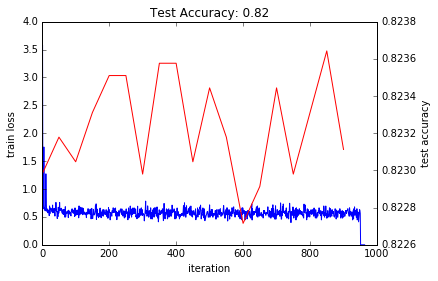

In [15]:
# Accuracy plot
_, ax1 = subplots()
ax2 = ax1.twinx()
ax1.plot(arange(niter), train_loss)
ax2.plot(test_interval * arange(len(test_acc)), test_acc, 'r')
ax1.set_xlabel('iteration')
ax1.set_ylabel('train loss')
ax2.set_ylabel('test accuracy')
ax2.set_title('Test Accuracy: {:.2f}'.format(test_acc[-1]))

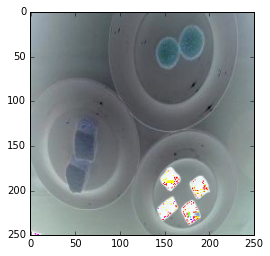

In [8]:
imshow(255*solver.test_nets[0].blobs['data'].data[0,:].transpose())

In [13]:
print output[:50, i].shape

(50, 2)
